In [1]:
import pandas as pd
import sys
import os

root = os.path.abspath(os.path.join('..'))
if root not in sys.path:
    sys.path.append(root)

from src.split import time_series_split
from src.metrics import regression_metrics
from src.models.xgb_model import train_xgb_regressor, predict

# Forecasting setup
TARGETS = ["requests", "bytes"]

HORIZONS = {
"1m": 1,
"5m": 5,
"15m": 15
}

SPLIT_DATE = "1995-08-23"

results = []

In [2]:
metrics = pd.read_csv("../data/processed/metrics_full.csv")
metrics["timestamp"] = pd.to_datetime(metrics["timestamp"])
metrics = metrics.set_index("timestamp")

metrics.shape

(89255, 25)

In [3]:
for target in TARGETS:
    for window_name, horizon in HORIZONS.items():

        print(f"Training XGBoost | Target={target} | Window={window_name}")

        label_col = f"{target}_future_{horizon}"

        X_train, X_test, y_train, y_test = time_series_split(
        metrics,
        split_date=SPLIT_DATE,
        label_col=label_col
        )

        model = train_xgb_regressor(X_train, y_train)
        y_pred = predict(model, X_test)

        scores = regression_metrics(y_test, y_pred)

        results.append({
        "Model": "XGBoost",
        "Target": target,
        "Window": window_name,
        **scores
        })

Training XGBoost | Target=requests | Window=1m
Training XGBoost | Target=requests | Window=5m
Training XGBoost | Target=requests | Window=15m
Training XGBoost | Target=bytes | Window=1m
Training XGBoost | Target=bytes | Window=5m
Training XGBoost | Target=bytes | Window=15m


In [4]:
results_df = pd.DataFrame(results)
results_df

,Model,Target,Window,RMSE,MSE,MAE,MAPE (%)
0,XGBoost,requests,1m,12.968975,1.681943e+02,9.643384,6.342465e+05
1,XGBoost,requests,5m,13.634422,1.858975e+02,10.175734,8.518794e+05
2,XGBoost,requests,15m,13.906367,1.933871e+02,10.374924,1.025118e+06
3,XGBoost,bytes,1m,443598.698151,1.967798e+11,321843.319930,2.805088e+10
4,XGBoost,bytes,5m,452446.182025,2.047075e+11,331566.841535,2.839445e+10
5,XGBoost,bytes,15m,461386.459738,2.128775e+11,342149.154760,3.174876e+10


In [5]:
results_df.to_csv("../data/processed/xgb_benchmark_results.csv", index=False)

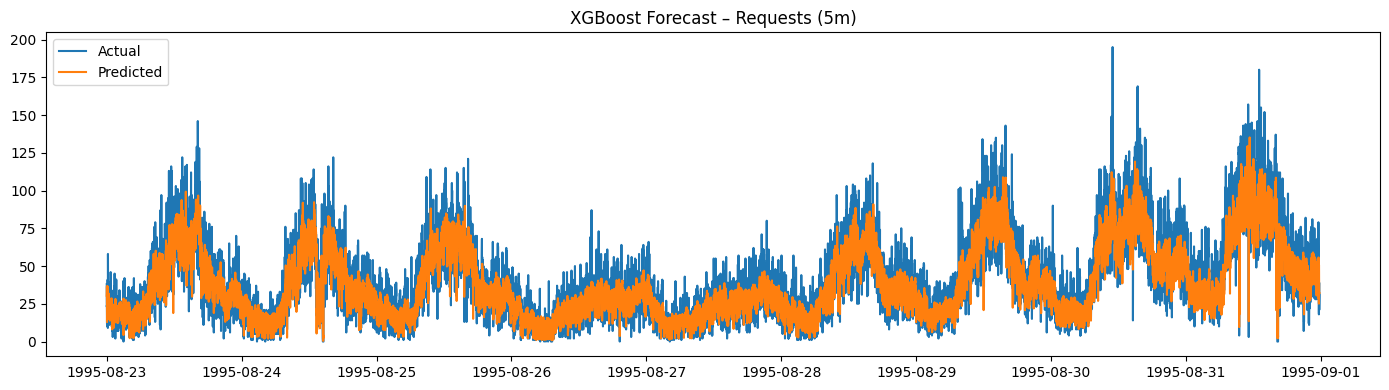

In [6]:
import matplotlib.pyplot as plt


example = results_df[(results_df["Target"] == "requests") & (results_df["Window"] == "5m")]
example
# Plot actual vs predicted for one case
label_col = "requests_future_5"

X_train, X_test, y_train, y_test = time_series_split(metrics,split_date=SPLIT_DATE,label_col=label_col)

model = train_xgb_regressor(X_train, y_train)
y_pred = predict(model, X_test)

plt.figure(figsize=(14,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("XGBoost Forecast – Requests (5m)")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# ==============================
# EXPORT FORECAST FOR AUTOSCALING
# ==============================

BEST_MODEL = "XGBoost"
BEST_HORIZON = 5   # 5 minutes

forecast_outputs = []

for target in ["requests", "bytes"]:
    print(f"Exporting forecast for {target} ({BEST_HORIZON}m)")

    label_col = f"{target}_future_{BEST_HORIZON}"

    X_train, X_test, y_train, y_test = time_series_split(
        metrics,
        split_date=SPLIT_DATE,
        label_col=label_col
    )

    model = train_xgb_regressor(X_train, y_train)
    y_pred = predict(model, X_test)

    forecast_outputs.append(
        pd.DataFrame({
            "timestamp": y_test.index,
            f"{target}_pred_5m": y_pred
        })
    )

# Merge requests + bytes forecast
forecast_df = forecast_outputs[0].merge(
    forecast_outputs[1],
    on="timestamp"
)

forecast_df.to_csv(
    "../data/processed/xgb_forecast_5m.csv",
    index=False
)

print("Saved XGBoost 5-minute forecast for autoscaling")
forecast_df.head()


Exporting forecast for requests (5m)
Exporting forecast for bytes (5m)
Saved XGBoost 5-minute forecast for autoscaling


,timestamp,requests_pred_5m,bytes_pred_5m
0,1995-08-23 00:00:00-04:00,30.331299,500923.81250
1,1995-08-23 00:01:00-04:00,31.937544,406712.09375
2,1995-08-23 00:02:00-04:00,36.572479,453406.09375
3,1995-08-23 00:03:00-04:00,12.881587,364076.68750
4,1995-08-23 00:04:00-04:00,26.972900,582348.75000
